In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Input, Concatenate
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization,Activation,Conv2D,Concatenate
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2L, Xception,ResNet50,InceptionResNetV2

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 建立資料集

In [2]:
batch_size=32
img_shape=(224,224)
input_shape=(224,224,3)

# train_data_dir = '/kaggle/input/traindataset/train'
train_data_dir='/kaggle/input/train-balance600/train (2)/train/train'
test_data_dir = '/kaggle/input/testdataset1/test/test'


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.2 , 
    height_shift_range=0.2 ,
    shear_range=0.2 ,
    zoom_range=0.2,  
    horizontal_flip=True,  
    vertical_flip=True  
)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_shape,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',  
)
val_generator=train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
)


# labels = train_generator.classes
# class_weights = compute_class_weight('balanced', classes=np.unique(labels),y=labels)
# class_weights_dict = dict(enumerate(class_weights))

Found 24432 images belonging to 50 classes.
Found 6086 images belonging to 50 classes.
Found 7002 images belonging to 50 classes.


# 建立模型

In [3]:
input_tensor = Input(shape=(224, 224, 3))
model1 = Xception(
    weights='imagenet', 
    include_top=False, 
    input_tensor=input_tensor)


model2 = EfficientNetV2L(
    weights='imagenet', 
    include_top=False, 
    include_preprocessing=False,
    input_tensor=input_tensor)
for layer in model1.layers[:-12]:
    layer.trainable = False
for layer in model2.layers[:-30]:
    layer.trainable = False
# model1.trainable=False
# model2.trainable=False

model1_output = model1.output
model2_output = model2.output

model1_output = GlobalAveragePooling2D()(model1_output)
model2_output = GlobalAveragePooling2D()(model2_output)

concatenated = Concatenate()([model1_output , model2_output])


x = Dense(1024, activation='relu')(concatenated)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(50, activation='softmax')(x)  


combined_model = Model(inputs=input_tensor, outputs=predictions)



473176280/473176280 [==============================] - 13s 0us/step


# 顯示模型

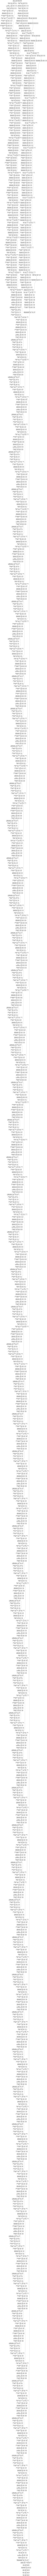

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(combined_model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

Image('model_plot.png')

In [5]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import math

@tf.function
def lr_scheduler(epoch, lr):
    if epoch % 8 == 0 and epoch != 0:
        lr = lr * 0.5
    if lr<1e-7:
        lr=1e-7
    return lr


In [6]:
my_callbacks=[
    tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            verbose=2,
            mode='auto'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5,
            verbose=2,
            min_lr=1e-7,
            mode='auto'
    ),
    tf.keras.callbacks.ModelCheckpoint(
            filepath="/kaggle/working/XceptionV2Lf.h5",
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_freq='epoch'
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
]

In [7]:
combined_model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=5,name='top_5_categorical_accuracy',dtype=None)])

In [8]:
epochs=25
history = combined_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
#     class_weight=class_weights_dict,
    verbose=1,
    callbacks=my_callbacks
)

Epoch 1/25


2024-01-08 12:40:00.433777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


760/764 [============================>.] - ETA: 2s - loss: 1.4206 - accuracy: 0.5783 - top_5_categorical_accuracy: 0.8689

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


764/764 [==============================] - ETA: 0s - loss: 1.4191 - accuracy: 0.5786 - top_5_categorical_accuracy: 0.8691

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


764/764 [==============================] - 717s 877ms/step - loss: 1.4191 - accuracy: 0.5786 - top_5_categorical_accuracy: 0.8691 - val_loss: 0.8220 - val_accuracy: 0.7263 - val_top_5_categorical_accuracy: 0.9629 - lr: 1.0000e-04
Epoch 2/25
764/764 [==============================] - 466s 609ms/step - loss: 0.8489 - accuracy: 0.7252 - top_5_categorical_accuracy: 0.9603 - val_loss: 0.7146 - val_accuracy: 0.7700 - val_top_5_categorical_accuracy: 0.9727 - lr: 1.0000e-04
Epoch 3/25
764/764 [==============================] - 463s 606ms/step - loss: 0.7190 - accuracy: 0.7623 - top_5_categorical_accuracy: 0.9718 - val_loss: 0.6729 - val_accuracy: 0.7795 - val_top_5_categorical_accuracy: 0.9755 - lr: 1.0000e-04
Epoch 4/25
764/764 [==============================] - 464s 607ms/step - loss: 0.6324 - accuracy: 0.7907 - top_5_categorical_accuracy: 0.9785 - val_loss: 0.6399 - val_accuracy: 0.7884 - val_top_5_categorical_accuracy: 0.9777 - lr: 1.0000e-04
Epoch 5/25
764/764 [===========================

# 畫出accuracy 以及loss curve

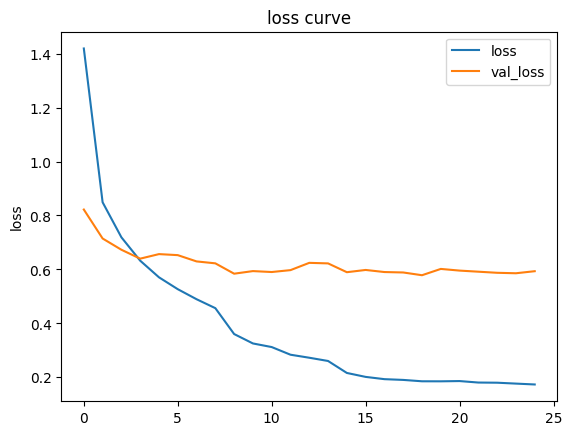

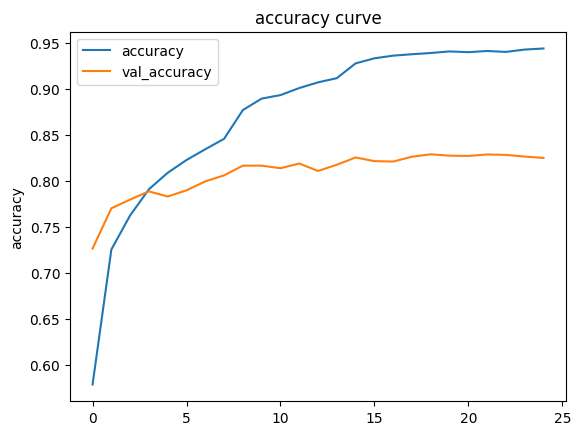

In [9]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Classification report 和Confusion matrix

219/219 [==============================] - 99s 416ms/step


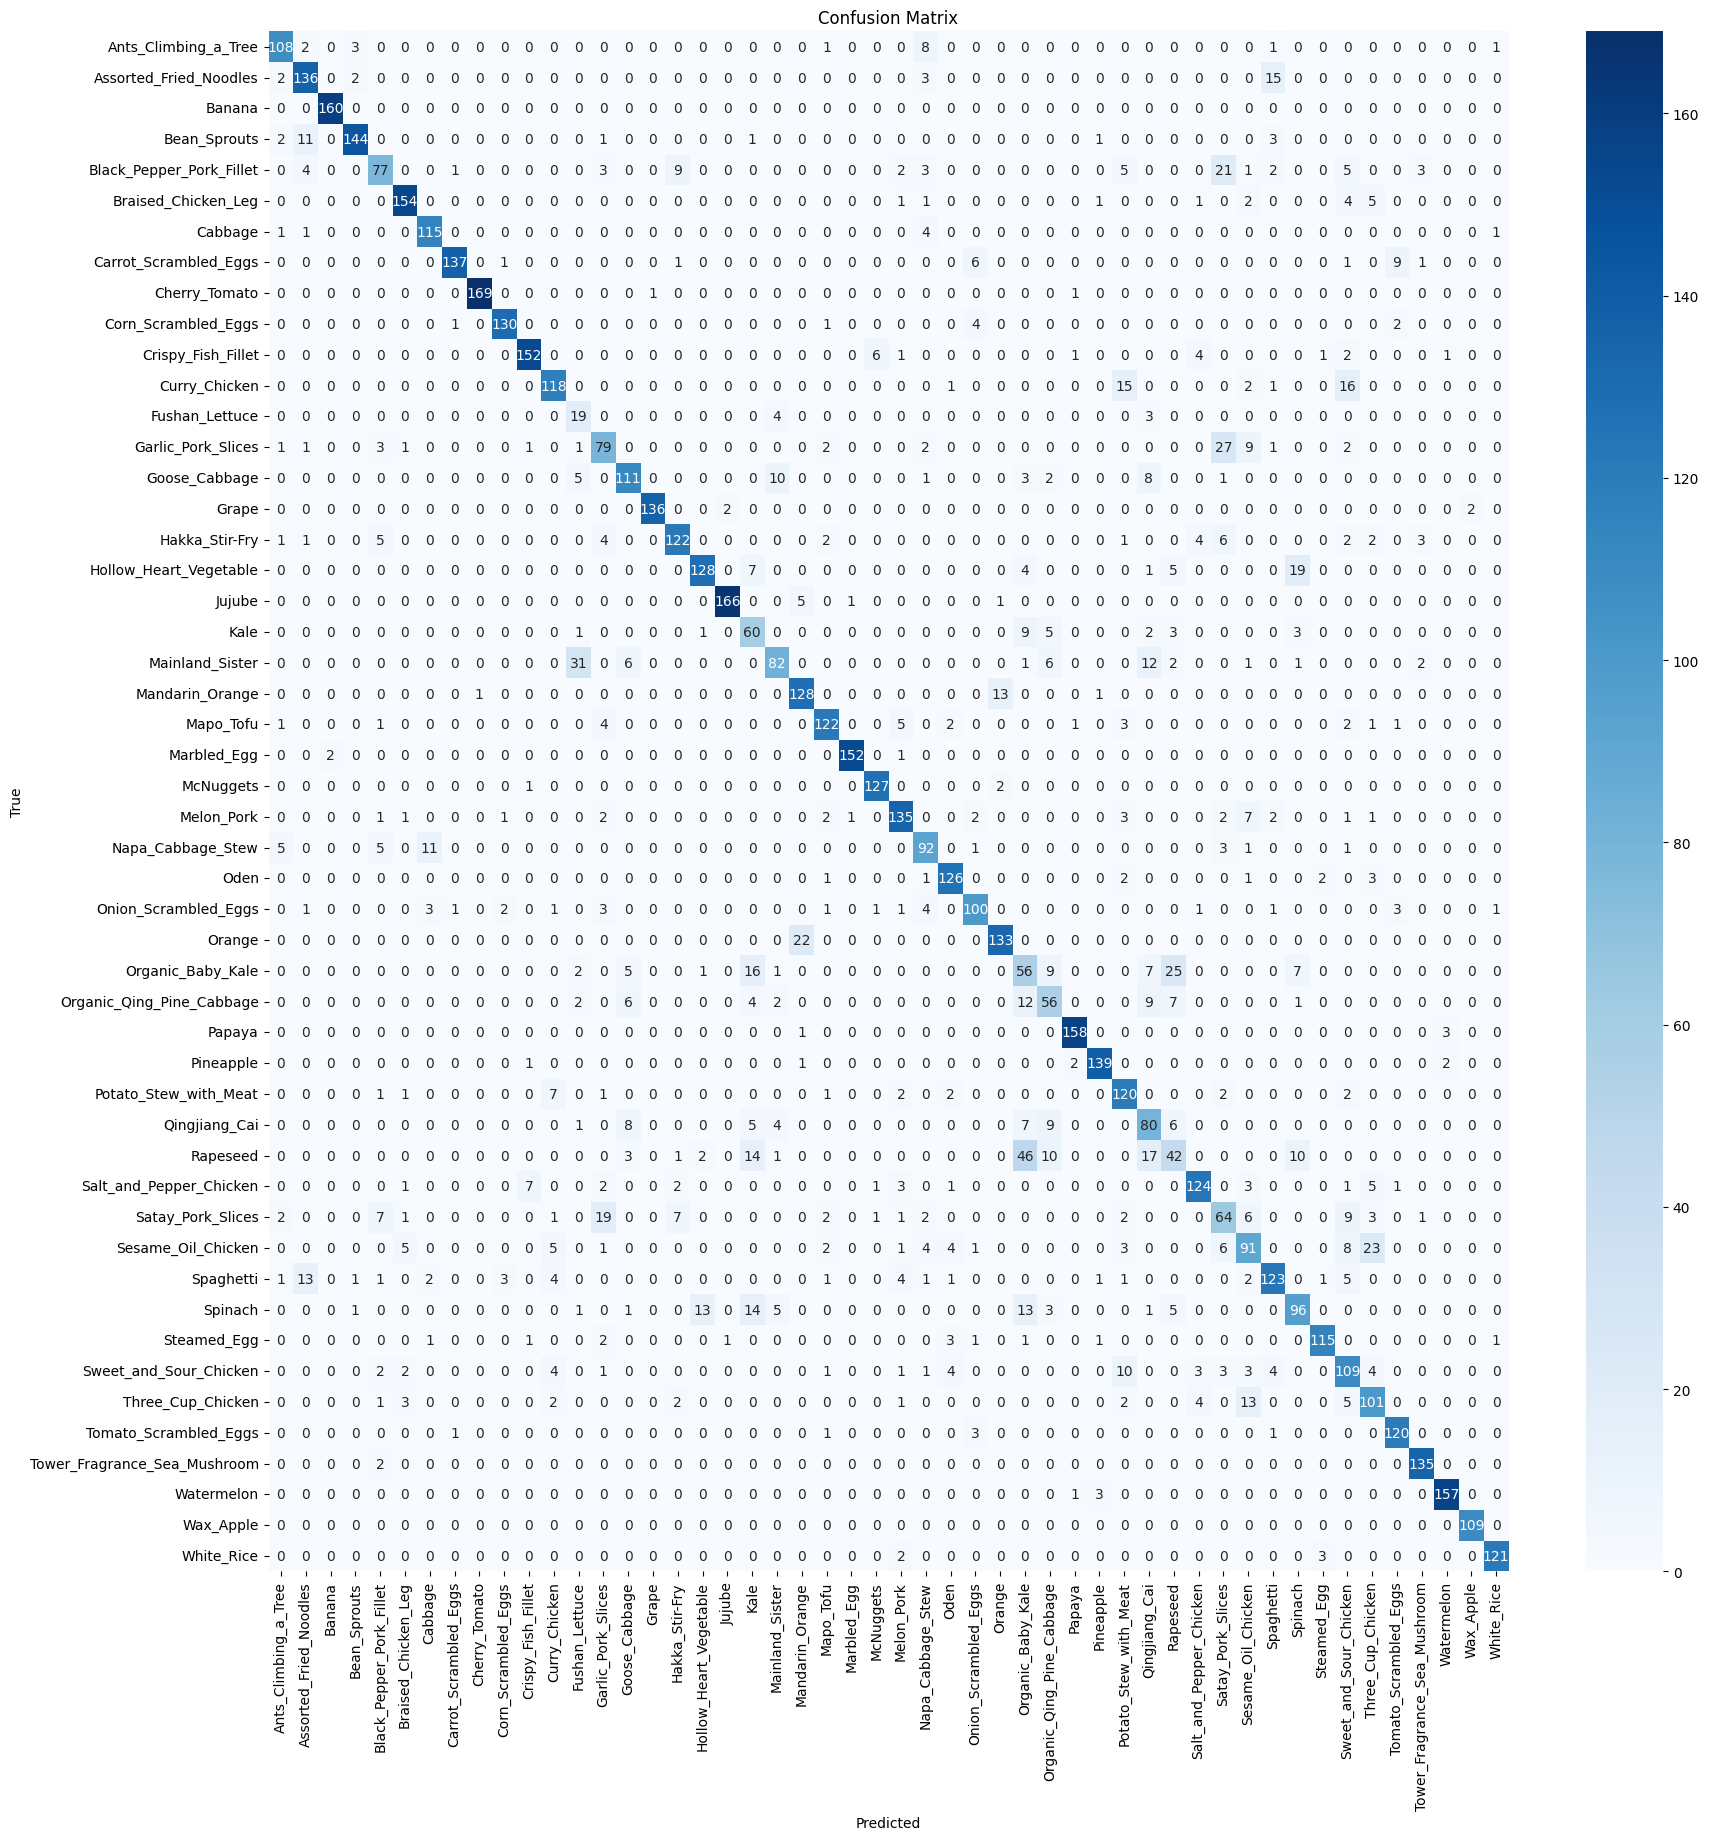

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical
class_indices = train_generator.class_indices


test_predictions = combined_model.predict(test_generator)

predicted_labels = np.argmax(test_predictions, axis=1)
predicted_class_names = [list(class_indices.keys())[i] for i in predicted_labels]
true_labels=test_generator.classes
true_class_names = [list(class_indices.keys())[i] for i in true_labels]

cm = confusion_matrix(true_class_names, predicted_class_names)


plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",  
            xticklabels=list(class_indices.keys()), 
            yticklabels=list(class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [11]:
report = classification_report(predicted_class_names, true_class_names)
print(report)

                              precision    recall  f1-score   support

        Ants_Climbing_a_Tree       0.87      0.87      0.87       124
      Assorted_Fried_Noodles       0.86      0.80      0.83       170
                      Banana       1.00      0.99      0.99       162
                Bean_Sprouts       0.88      0.95      0.92       151
    Black_Pepper_Pork_Fillet       0.57      0.73      0.64       106
         Braised_Chicken_Leg       0.91      0.91      0.91       169
                     Cabbage       0.94      0.87      0.91       132
       Carrot_Scrambled_Eggs       0.88      0.97      0.92       141
               Cherry_Tomato       0.99      0.99      0.99       170
         Corn_Scrambled_Eggs       0.94      0.95      0.95       137
          Crispy_Fish_Fillet       0.90      0.93      0.92       163
               Curry_Chicken       0.77      0.83      0.80       142
              Fushan_Lettuce       0.73      0.30      0.43        63
          Garlic_Po

# 畫出Top 5 Accuracy curve

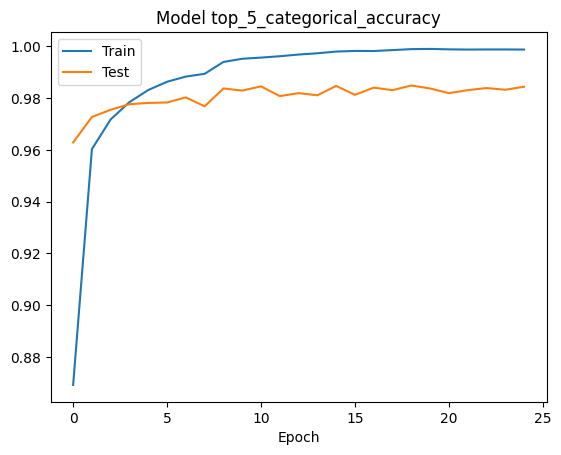

In [12]:
plt.plot(history.history['top_5_categorical_accuracy'])
plt.plot(history.history['val_top_5_categorical_accuracy'])
plt.title('Model top_5_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'],loc='upper left')
plt.show()